In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

## Set the seed for reproducibility

In [2]:
SEED = 44
np.random.seed(SEED)
random.seed(SEED)

## Load the data

In [3]:
import os

data_path = "data/features/genimage-512x512/jpg100"
suffix = "features/extraction_params/train/features_RGB.csv"
biggan_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan", suffix), index_col=0)
vqdm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm", suffix), index_col=0)
sdv5_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5", suffix), index_col=0)
wukong_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong", suffix), index_col=0)
adm_train = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm", suffix), index_col=0)
glide_train = pd.read_csv(os.path.join(data_path, "imagenet_glide", suffix), index_col=0)
midjourney_train = pd.read_csv(os.path.join(data_path, "imagenet_midjourney", suffix), index_col=0)
mid_sd = pd.concat([sdv5_train, midjourney_train])
combined_train = pd.concat([biggan_train, vqdm_train, sdv5_train, wukong_train, adm_train, glide_train, midjourney_train])

datasets_train = {
    "biggan": biggan_train,
    "vqdm": vqdm_train,
    "sdv5": sdv5_train,
    "wukong": wukong_train,
    "adm": adm_train,
    "glide": glide_train,
    "midjourney": midjourney_train,
    "mid_sd": mid_sd,
    "combined": combined_train,
}

In [4]:
suffix = "features/extraction_params/val/features_RGB.csv"
biggan_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_biggan", suffix), index_col=0)
vqdm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0419_vqdm", suffix), index_col=0)
sdv5_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_sdv5", suffix), index_col=0)
wukong_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0424_wukong", suffix), index_col=0)
adm_test = pd.read_csv(os.path.join(data_path, "imagenet_ai_0508_adm", suffix), index_col=0)
glide_test = pd.read_csv(os.path.join(data_path, "imagenet_glide", suffix), index_col=0)
midjourney_test = pd.read_csv(os.path.join(data_path, "imagenet_midjourney", suffix), index_col=0)
mid_sd = pd.concat([sdv5_test, midjourney_test])
combined_test = pd.concat([biggan_test, vqdm_test, sdv5_test, wukong_test, adm_test, glide_test, midjourney_test])

datasets_test = {
    "biggan": biggan_test,
    "vqdm": vqdm_test,
    "sdv5": sdv5_test,
    "wukong": wukong_test,
    "adm": adm_test,
    "glide": glide_test,
    "midjourney": midjourney_test,
    "mid_sd": mid_sd,
    "combined": combined_test,
}

## Data preparation

In [5]:
def drop_columns(df, drop_only_diagnostic=False):
    for column in df.columns:
        if df[column].min() == df[column].max() and not drop_only_diagnostic:
            df.drop(column, axis=1, inplace=True)
        elif 'diagnostics' in column:
            df.drop(column, axis=1, inplace=True)
        elif 'Mask' in column:
            df.drop(column, axis=1, inplace=True)
            
def preprocess_dataset(df, **kwargs):
    # print indexes and image names of rows with NaN values
    nans = df[df.isnull().any(axis=1)]['Image'].apply(lambda x : x.split('/')[-1])
    if not nans.empty:
        print(f"Rows with NaN values:")
        print(nans)
    df.dropna(inplace=True)  
    drop_columns(df, **kwargs)
    
def unify_columns(base_columns, df):
    # drop columns that are not in base_columns
    for column in df.columns:
        if column not in base_columns:
            df.drop(column, axis=1, inplace=True)

### Drop unimportant columns

In [6]:
# We drop only columns from train set
for key, df in datasets_train.items():
    preprocess_dataset(df, drop_only_diagnostic=True)

### Split into train and test set

In [7]:
from sklearn.model_selection import train_test_split

X_train = {}
X_val = {}

y_train = {}
y_val = {}

Image_train = {}
Image_val = {}

for key, df in datasets_train.items():
    X = df.drop('Category', axis=1)
    y = df['Category']
    
    X_train[key], X_val[key], y_train[key], y_val[key] = train_test_split(X, y, test_size=0.2, random_state=SEED)
    
    Image_train[key] = X_train[key]['Image']
    Image_val[key] = X_val[key]['Image']
    
    X_train[key] = X_train[key].drop('Image', axis=1)
    X_val[key] = X_val[key].drop('Image', axis=1)

### Scale the data

In [8]:
from sklearn.preprocessing import MinMaxScaler

scalers = {}
X_train_scaled = {}
for key in datasets_train.keys():
    scalers[key] = MinMaxScaler()
    X_train_scaled[key] = scalers[key].fit_transform(X_train[key])
    X_train_scaled[key] = pd.DataFrame(X_train_scaled[key], columns=X_train[key].columns)

## Model training

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

models = {}
for dataset_name in datasets_train.keys():
    print(f"\n\nTraining set: {dataset_name}\n")

    models_temp = [
        HistGradientBoostingClassifier(random_state=SEED),
        LinearDiscriminantAnalysis(),
        RandomForestClassifier(random_state=SEED),
        LinearSVC(random_state=SEED)
    ]

    model_temp_dict = { model.__class__.__name__: model for model in models_temp }

    for name, model in model_temp_dict.items():
        model = model.fit(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())
        print(f"Finished training {name}.")
        print(f"Training accuracy: {model.score(X_train_scaled[dataset_name], y_train[dataset_name].values.ravel())}")
        
    models[dataset_name] = model_temp_dict



Training set: biggan

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: vqdm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: sdv5

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.995


Training set: wukong

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.9928125


Training set: adm

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: glide

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 1.0
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 1.0


Training set: midjourney

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9996875
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.98


Training set: mid_sd

Finished training HistGradientBoostingClassifier.
Training accuracy: 1.0
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.98953125
Finished training RandomForestClassifier.
Training accuracy: 1.0


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Finished training LinearSVC.
Training accuracy: 0.965


Training set: combined

Finished training HistGradientBoostingClassifier.
Training accuracy: 0.9839285714285714
Finished training LinearDiscriminantAnalysis.
Training accuracy: 0.9765625
Finished training RandomForestClassifier.
Training accuracy: 1.0
Finished training LinearSVC.
Training accuracy: 0.9534375


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Evaluation

In [10]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    confusion_matrix, ConfusionMatrixDisplay, matthews_corrcoef

def evaluate_model(model, X_test, y_test, print_results=True, name=None):
    if name is not None:
        name = model.__class__.__name__
    
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    mcc = matthews_corrcoef(y_test, y_pred)
    
    if print_results:
        print(f"Model: {name}")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"F1: {f1:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print(f"MCC: {mcc:.4f}")
    
    return accuracy, f1, precision, recall, mcc

def plot_confusion_matrix(model, X_test, y_test, name=None):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(name)
    plt.show()

In [11]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for val_dataset_name in X_val.keys():
        print(f"\n\nValidation set: {val_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_val_scaled = scalers[dataset_name].transform(X_val[val_dataset_name][X_train[dataset_name].columns])
            X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_val_scaled, y_val[val_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, val_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on biggan. ***


Validation set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: LinearDiscriminantAnalysis
Accuracy: 0.9862
F1: 0.9862
Precision: 0.9863
Recall: 0.9862
MCC: 0.9726

Model: RandomForestClassifier
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950

Model: LinearSVC
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950


Validation set: vqdm

Model: HistGradientBoostingClassifier
Accuracy: 0.6100
F1: 0.5400
Precision: 0.7809
Recall: 0.6100
MCC: 0.3516

Model: LinearDiscriminantAnalysis
Accuracy: 0.6700
F1: 0.6330
Precision: 0.7849
Recall: 0.6700
MCC: 0.4401

Model: RandomForestClassifier
Accuracy: 0.6325
F1: 0.5760
Precision: 0.7837
Recall: 0.6325
MCC: 0.3877

Model: LinearSVC
Accuracy: 0.5850
F1: 0.4987
Precision: 0.7732
Recall: 0.5850
MCC: 0.3048


Validation set: sdv5



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5038
F1: 0.3542
Precision: 0.5510
Recall: 0.5038
MCC: 0.0276



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: wukong



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3568
Precision: 0.5638
Recall: 0.5050
MCC: 0.0357

Model: RandomForestClassifier
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: adm



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5075
F1: 0.3498
Precision: 0.7519
Recall: 0.5075
MCC: 0.0869

Model: LinearDiscriminantAnalysis
Accuracy: 0.5463
F1: 0.4334
Precision: 0.7273
Recall: 0.5463
MCC: 0.2051

Model: RandomForestClassifier
Accuracy: 0.5125
F1: 0.3605
Precision: 0.7532
Recall: 0.5125
MCC: 0.1125

Model: LinearSVC
Accuracy: 0.5025
F1: 0.3410
Precision: 0.6256
Recall: 0.5025
MCC: 0.0354


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9850
F1: 0.9850
Precision: 0.9854
Recall: 0.9850
MCC: 0.9704

Model: LinearDiscriminantAnalysis
Accuracy: 0.8363
F1: 0.8320
Precision: 0.8739
Recall: 0.8363
MCC: 0.7092

Model: RandomForestClassifier
Accuracy: 0.9862
F1: 0.9862
Precision: 0.9865
Recall: 0.9862
MCC: 0.9727

Model: LinearSVC
Accuracy: 0.9487
F1: 0.9486
Precision: 0.9535
Recall: 0.9487
MCC: 0.9023


Validation set: midjourney



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5012
F1: 0.3405
Precision: 0.5503
Recall: 0.5012
MCC: 0.0159

Model: RandomForestClassifier
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354

Model: LinearSVC
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501


Validation set: mid_sd

Model: HistGradientBoostingClassifier
Accuracy: 0.4913
F1: 0.3241
Precision: 0.2418
Recall: 0.4913
MCC: -0.0254

Model: LinearDiscriminantAnalysis
Accuracy: 0.4956
F1: 0.3390
Precision: 0.5816
Recall: 0.4956
MCC: 0.0338

Model: RandomForestClassifier
Accuracy: 0.4913
F1: 0.3241
Precision: 0.2418
Recall: 0.4913
MCC: -0.0254

Model: LinearSVC
Accuracy: 0.4906
F1: 0.3238
Precision: 0.2416
Recall: 0.4906
MCC: -0.0360


Validation set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6575
F1: 0.6104
Precision: 0.7960
Recall: 0.6575
MCC: 0.4287

M

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3410
Precision: 0.6256
Recall: 0.5025
MCC: 0.0354

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3432
Precision: 0.5840
Recall: 0.5025
MCC: 0.0290

Model: RandomForestClassifier
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Validation set: adm

Model: HistGradientBoostingClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.9938
F1: 0.9937
Precision: 0.9938
Recall: 0.9938
MCC: 0.9875

Model: RandomForestClassifier
Accuracy: 0.9925
F1: 0.9925
Precision: 0.9925
Recall: 0.9925
MCC: 0.9850

Model: LinearSVC
Accuracy: 0.9975
F1: 0.9975
Precision: 0.9975
Recall: 0.9975
MCC: 0.9950


Validation set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5725
F1: 0.4796
Precision: 0.7535
Recall: 0.5725
MCC: 0.2711

Model: LinearDiscriminantAnalysis
Accuracy: 0.6025
F1: 0.5290
Precision: 0.7727
Recall: 0.6025
MCC: 0.3344

Model: RandomForestClassifier
Accuracy: 0.9888
F1: 0.9887
Precision: 0.9888
Recall: 0.9888
MCC: 0.9775

Model: LinearSVC
Accuracy: 0.9113
F1: 0.9106
Precision: 0.9239
Recall: 0.9113
MCC: 0.8350


Validation set: midjourney

Mode

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3410
Precision: 0.6256
Recall: 0.5025
MCC: 0.0354

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4988
F1: 0.3328
Precision: 0.2497
Recall: 0.4988
MCC: -0.0354


Validation set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709

Model: LinearDiscriminantAnalysis
Accuracy: 0.5038
F1: 0.3521
Precision: 0.5586
Recall: 0.5038
MCC: 0.0297

Model: RandomForestClassifier
Accuracy: 0.4975
F1: 0.3322
Precision: 0.2494
Recall: 0.4975
MCC: -0.0501

Model: LinearSVC
Accuracy: 0.4950
F1: 0.3311
Precision: 0.2487
Recall: 0.4950
MCC: -0.0709


Validation set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5675
F1: 0.4708
Precision: 0.7510
Recall: 0.5675
MCC: 0.2603

Model: LinearDiscriminantAnalysis
Accuracy: 0.8875
F1: 0.8862
Precision: 0.9054
Recall: 0.8875
MCC: 0.7927

Model: RandomForestClassifier
Accuracy: 0.5500
F1: 0.4373
Precision: 0.7513
Recall: 0.5500
MCC: 0.2242

Model: LinearSVC
Accuracy: 0.6500
F1: 0.6035
Precision: 0.7826
Recall: 0.6500
MCC: 0.4118


Validation set: glide

Mode

In [12]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "val_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="val_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

In [13]:
def present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy"):
    # Get only for the LDA model
    model_df = df[df["model"] == name]
    # Leave only the accuracy, train_dataset, and val_dataset columns
    val_dataset_name = "val_dataset" if evaluation_data_name == "Validation" else "test_dataset"
    model_df = model_df[["train_dataset", val_dataset_name, metric]]
    # Pivot the table
    df_pivot = model_df.pivot(index="train_dataset", columns=val_dataset_name, values=metric)
    # reorganize columns and indexes in order Midjourney, SDv5, ADM, GLIDE, WukoNG, VQDM, BigGAN, Combined
    df_pivot = df_pivot.reindex(index=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])
    df_pivot = df_pivot.reindex(columns=["midjourney", "sdv5", "adm", "glide", "wukong", "vqdm", "biggan", "mid_sd", "combined"])

    plt.figure(figsize=(10, 7))
    plt.imshow(df_pivot, cmap=cmap, interpolation='nearest')
    plt.colorbar()
    plt.xticks(np.arange(len(df_pivot.columns)), df_pivot.columns, rotation=45)
    plt.yticks(np.arange(len(df_pivot.index)), df_pivot.index)
    plt.xlabel(f"{evaluation_data_name} dataset")
    plt.ylabel("Train dataset")
    plt.title(f"Accuracy - {name}")
    plt.show()
    
    display(df_pivot)
    
    # exclude combined val_dataset
    df_avg = df_pivot.drop("combined", axis=1)
    # calculate average accuracy for each train dataset (don't include combined)
    df_avg["average"] = df_avg.mean(axis=1)
    display(df_avg)

    return df_pivot, df_avg

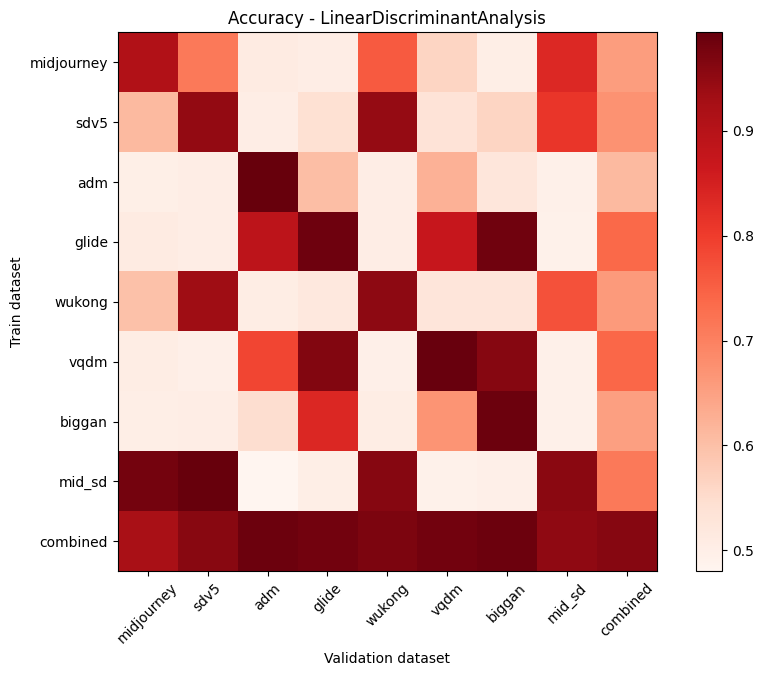

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.90750,0.71125,0.50875,0.50250,0.75875,0.56375,0.50125,0.835000,0.656071
sdv5,0.60875,0.94625,0.50375,0.54125,0.94375,0.53250,0.56375,0.810000,0.672321
adm,0.50000,0.50250,0.99375,0.60250,0.50250,0.62250,0.52500,0.494375,0.609107
glide,0.51000,0.50250,0.88750,0.98500,0.50375,0.87250,0.98250,0.492500,0.737679
wukong,0.59750,0.93500,0.50500,0.51875,0.95250,0.52625,0.52625,0.770625,0.660179
vqdm,0.50500,0.49750,0.78625,0.96375,0.49750,0.99000,0.96000,0.495000,0.739643
biggan,0.50125,0.50375,0.54625,0.83625,0.50500,0.67000,0.98625,0.495625,0.651607
mid_sd,0.97875,0.99250,0.48000,0.50125,0.96000,0.49250,0.49625,0.955625,0.711429
combined,0.92125,0.95875,0.98750,0.98125,0.97000,0.98125,0.98625,0.950625,0.959821


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.90750,0.71125,0.50875,0.50250,0.75875,0.56375,0.50125,0.835000,0.661094
sdv5,0.60875,0.94625,0.50375,0.54125,0.94375,0.53250,0.56375,0.810000,0.681250
adm,0.50000,0.50250,0.99375,0.60250,0.50250,0.62250,0.52500,0.494375,0.592891
glide,0.51000,0.50250,0.88750,0.98500,0.50375,0.87250,0.98250,0.492500,0.717031
wukong,0.59750,0.93500,0.50500,0.51875,0.95250,0.52625,0.52625,0.770625,0.666484
vqdm,0.50500,0.49750,0.78625,0.96375,0.49750,0.99000,0.96000,0.495000,0.711875
biggan,0.50125,0.50375,0.54625,0.83625,0.50500,0.67000,0.98625,0.495625,0.630547
mid_sd,0.97875,0.99250,0.48000,0.50125,0.96000,0.49250,0.49625,0.955625,0.732109
combined,0.92125,0.95875,0.98750,0.98125,0.97000,0.98125,0.98625,0.950625,0.967109


In [14]:
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Validation", metric="accuracy")

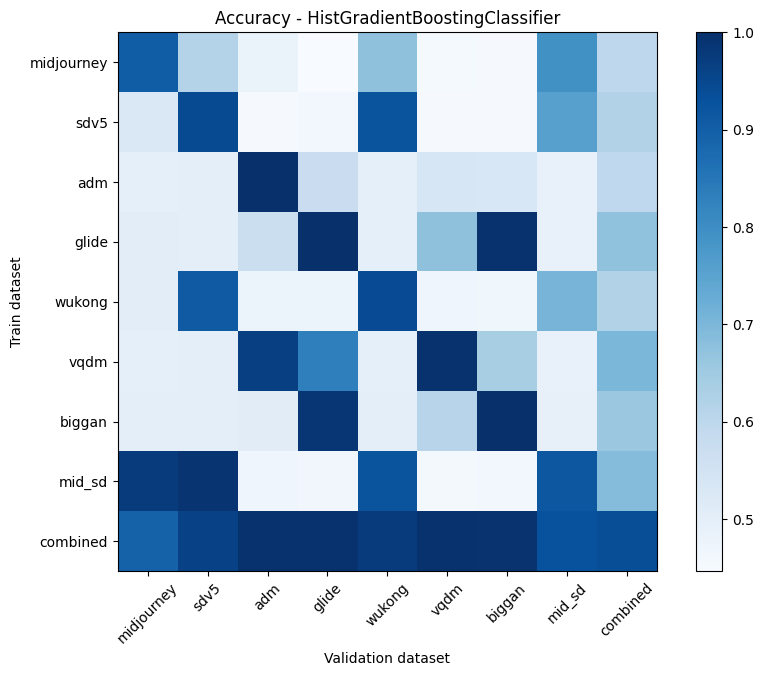

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.90375,0.61500,0.4825,0.44625,0.67500,0.45375,0.45125,0.792500,0.599464
sdv5,0.52625,0.94375,0.4525,0.46125,0.92250,0.45125,0.45125,0.757500,0.621429
adm,0.49750,0.50000,1.0000,0.57250,0.49750,0.53625,0.53250,0.488125,0.593571
glide,0.50250,0.50000,0.5675,0.99875,0.49500,0.67375,0.99500,0.488750,0.673036
wukong,0.50375,0.91000,0.4750,0.47875,0.94125,0.47000,0.46625,0.706875,0.618036
vqdm,0.49500,0.49875,0.9675,0.83000,0.49625,0.99500,0.63625,0.485625,0.699464
biggan,0.50000,0.50000,0.5075,0.98500,0.50000,0.61000,0.99750,0.491250,0.657500
mid_sd,0.97500,0.98750,0.4700,0.46500,0.92250,0.45750,0.46000,0.917500,0.688393
combined,0.89375,0.96250,0.9950,0.99500,0.97500,0.99375,0.99250,0.928750,0.935357


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.90375,0.61500,0.4825,0.44625,0.67500,0.45375,0.45125,0.792500,0.602500
sdv5,0.52625,0.94375,0.4525,0.46125,0.92250,0.45125,0.45125,0.757500,0.620781
adm,0.49750,0.50000,1.0000,0.57250,0.49750,0.53625,0.53250,0.488125,0.578047
glide,0.50250,0.50000,0.5675,0.99875,0.49500,0.67375,0.99500,0.488750,0.652656
wukong,0.50375,0.91000,0.4750,0.47875,0.94125,0.47000,0.46625,0.706875,0.618984
vqdm,0.49500,0.49875,0.9675,0.83000,0.49625,0.99500,0.63625,0.485625,0.675547
biggan,0.50000,0.50000,0.5075,0.98500,0.50000,0.61000,0.99750,0.491250,0.636406
mid_sd,0.97500,0.98750,0.4700,0.46500,0.92250,0.45750,0.46000,0.917500,0.706875
combined,0.89375,0.96250,0.9950,0.99500,0.97500,0.99375,0.99250,0.928750,0.967031


In [15]:
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name="Validation", metric="accuracy")

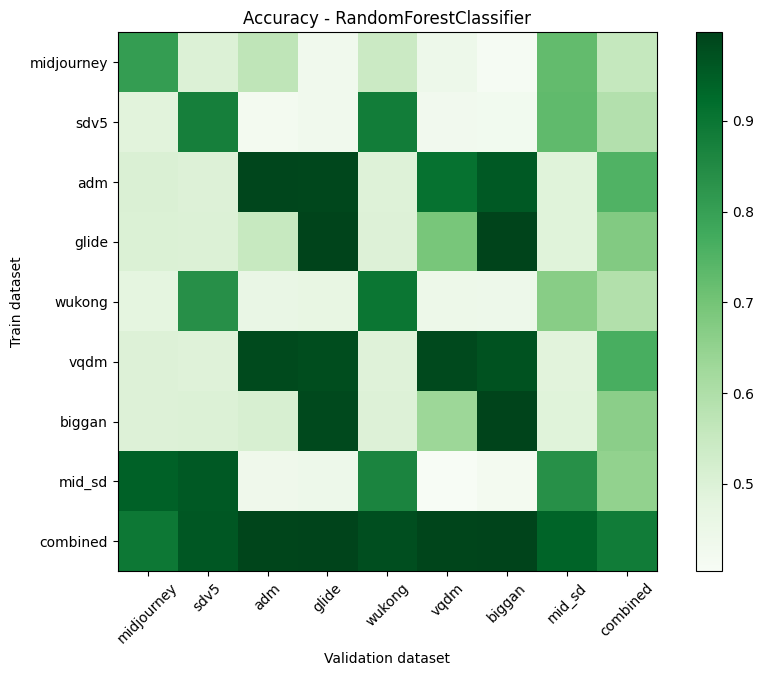

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.80625,0.50000,0.56625,0.43375,0.54125,0.44250,0.40875,0.725625,0.555714
sdv5,0.48500,0.87625,0.42125,0.43125,0.88250,0.42875,0.42500,0.730625,0.590536
adm,0.50375,0.49750,0.99250,0.98875,0.49500,0.90875,0.95750,0.490000,0.753393
glide,0.50125,0.50000,0.55000,0.99750,0.49750,0.69250,0.99625,0.490000,0.675357
wukong,0.47750,0.83750,0.46125,0.46500,0.89875,0.44500,0.44250,0.668125,0.592500
vqdm,0.49875,0.49375,0.98500,0.98125,0.49250,0.98625,0.97125,0.485625,0.764464
biggan,0.49875,0.50000,0.51250,0.98625,0.49875,0.63250,0.99750,0.491250,0.662321
mid_sd,0.94375,0.95625,0.43625,0.44250,0.86375,0.40375,0.42000,0.836875,0.649643
combined,0.89500,0.96250,0.99500,0.99750,0.97875,0.99500,0.99750,0.938125,0.885000


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.80625,0.50000,0.56625,0.43375,0.54125,0.44250,0.40875,0.725625,0.553047
sdv5,0.48500,0.87625,0.42125,0.43125,0.88250,0.42875,0.42500,0.730625,0.585078
adm,0.50375,0.49750,0.99250,0.98875,0.49500,0.90875,0.95750,0.490000,0.729219
glide,0.50125,0.50000,0.55000,0.99750,0.49750,0.69250,0.99625,0.490000,0.653125
wukong,0.47750,0.83750,0.46125,0.46500,0.89875,0.44500,0.44250,0.668125,0.586953
vqdm,0.49875,0.49375,0.98500,0.98125,0.49250,0.98625,0.97125,0.485625,0.736797
biggan,0.49875,0.50000,0.51250,0.98625,0.49875,0.63250,0.99750,0.491250,0.639687
mid_sd,0.94375,0.95625,0.43625,0.44250,0.86375,0.40375,0.42000,0.836875,0.662891
combined,0.89500,0.96250,0.99500,0.99750,0.97875,0.99500,0.99750,0.938125,0.969922


In [16]:
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name="Validation", metric="accuracy")

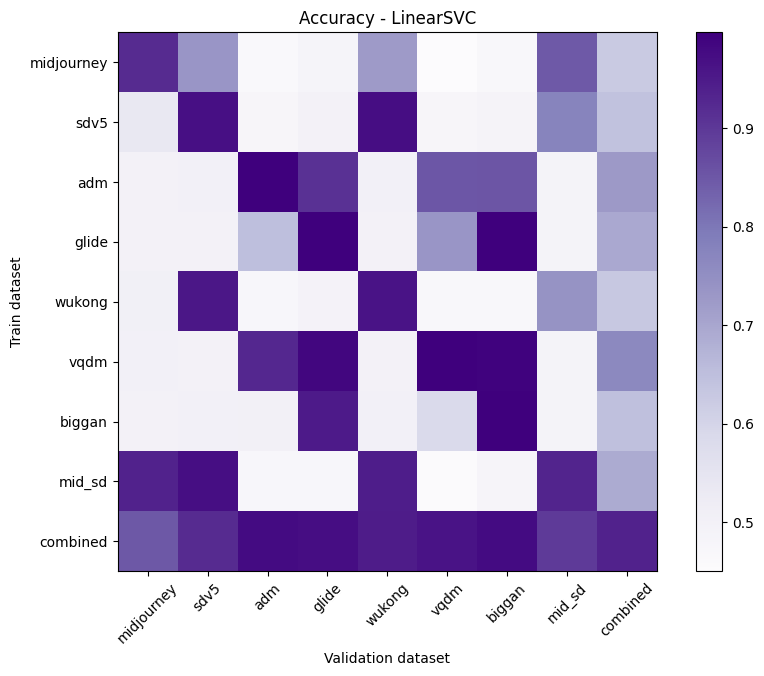

val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.92125,0.73250,0.46125,0.48250,0.72250,0.45000,0.46875,0.846250,0.624643
sdv5,0.53750,0.96875,0.47750,0.49625,0.97375,0.47625,0.48750,0.773750,0.643214
adm,0.49500,0.50000,0.99750,0.91125,0.50000,0.85125,0.85250,0.490625,0.724643
glide,0.49750,0.49875,0.65000,0.99750,0.49500,0.73375,0.99750,0.490000,0.695179
wukong,0.50500,0.95500,0.47250,0.49125,0.96250,0.47000,0.47125,0.740625,0.629643
vqdm,0.50125,0.49750,0.92750,0.98625,0.49875,0.99750,0.99250,0.490000,0.763036
biggan,0.49750,0.50000,0.50250,0.94875,0.50000,0.58500,0.99750,0.490625,0.647857
mid_sd,0.93750,0.97000,0.47250,0.47500,0.94500,0.45625,0.48125,0.933125,0.690000
combined,0.84875,0.92250,0.97625,0.97375,0.94625,0.96125,0.97750,0.895625,0.936607


val_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.92125,0.73250,0.46125,0.48250,0.72250,0.45000,0.46875,0.846250,0.635625
sdv5,0.53750,0.96875,0.47750,0.49625,0.97375,0.47625,0.48750,0.773750,0.648906
adm,0.49500,0.50000,0.99750,0.91125,0.50000,0.85125,0.85250,0.490625,0.699766
glide,0.49750,0.49875,0.65000,0.99750,0.49500,0.73375,0.99750,0.490000,0.670000
wukong,0.50500,0.95500,0.47250,0.49125,0.96250,0.47000,0.47125,0.740625,0.633516
vqdm,0.50125,0.49750,0.92750,0.98625,0.49875,0.99750,0.99250,0.490000,0.736406
biggan,0.49750,0.50000,0.50250,0.94875,0.50000,0.58500,0.99750,0.490625,0.627734
mid_sd,0.93750,0.97000,0.47250,0.47500,0.94500,0.45625,0.48125,0.933125,0.708828
combined,0.84875,0.92250,0.97625,0.97375,0.94625,0.96125,0.97750,0.895625,0.937734


In [17]:
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name="Validation", metric="accuracy")

## Evaluate on test data

In [18]:
X_test = {}
y_test = {}

for key, df in datasets_test.items():
    X_test[key] = df.drop('Category', axis=1)
    y_test[key] = df['Category']

In [19]:
results = {}
for dataset_name in models.keys():
    print(f"\n\n\n\n *** Evaluating models trained on {dataset_name}. ***")
    for test_dataset_name in X_test.keys():
        print(f"\n\nTest set: {test_dataset_name}")
        for model_name, model in models[dataset_name].items():
            print()  
            X_test_scaled = scalers[dataset_name].transform(X_test[test_dataset_name][X_train[dataset_name].columns])
            X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train[dataset_name].columns)
            accuracy, f1, precision, recall, mcc = evaluate_model(model, X_test_scaled, y_test[test_dataset_name], name=model_name)
            model_results = {
                "accuracy": accuracy,
                "f1": f1,
                "precision": precision,
                "recall": recall,
                "mcc": mcc
            }
            results[(dataset_name, test_dataset_name, model_name)] = model_results
            
            





 *** Evaluating models trained on biggan. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.9980
F1: 0.9980
Precision: 0.9980
Recall: 0.9980
MCC: 0.9960

Model: LinearDiscriminantAnalysis
Accuracy: 0.9880
F1: 0.9880
Precision: 0.9881
Recall: 0.9880
MCC: 0.9761

Model: RandomForestClassifier
Accuracy: 0.9980
F1: 0.9980
Precision: 0.9980
Recall: 0.9980
MCC: 0.9960

Model: LinearSVC
Accuracy: 0.9990
F1: 0.9990
Precision: 0.9990
Recall: 0.9990
MCC: 0.9980


Test set: vqdm

Model: HistGradientBoostingClassifier
Accuracy: 0.5940
F1: 0.5139
Precision: 0.7759
Recall: 0.5940
MCC: 0.3221

Model: LinearDiscriminantAnalysis
Accuracy: 0.6900
F1: 0.6598
Precision: 0.7947
Recall: 0.6900
MCC: 0.4732

Model: RandomForestClassifier
Accuracy: 0.6080
F1: 0.5368
Precision: 0.7803
Recall: 0.6080
MCC: 0.3480

Model: LinearSVC
Accuracy: 0.5690
F1: 0.4707
Precision: 0.7685
Recall: 0.5690
MCC: 0.2722


Test set: sdv5

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333


d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5010
F1: 0.3425
Precision: 0.5280
Recall: 0.5010
MCC: 0.0106

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316

Model: LinearDiscriminantAnalysis
Accuracy: 0.5020
F1: 0.3480
Precision: 0.5362
Recall: 0.5020
MCC: 0.0170

Model: RandomForestClassifier
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5090
F1: 0.3547
Precision: 0.7068
Recall: 0.5090
MCC: 0.0863

Model: LinearDiscriminantAnalysis
Accuracy: 0.5330
F1: 0.4097
Precision: 0.7005
Recall: 0.5330
MCC: 0.1627

Model: RandomForestClassifier
Accuracy: 0.5140
F1: 0.3637
Precision: 0.7535
Recall: 0.5140
MCC: 0.1192

Model: LinearSVC
Accuracy: 0.5050
F1: 0.3443
Precision: 0.7513
Recall: 0.5050
MCC: 0.0709


Test set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.9890
F1: 0.9890
Precision: 0.9892
Recall: 0.9890
MCC: 0.9782

Model: LinearDiscriminantAnalysis
Accuracy: 0.8510
F1: 0.8481
Precision: 0.8804
Recall: 0.8510
MCC: 0.7308

Model: RandomForestClassifier
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900

Model: LinearSVC
Accuracy: 0.9520
F1: 0.9519
Precision: 0.9559
Recall: 0.9520
MCC: 0.9079


Test set: midjourney

Model: HistGradientBoo

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5090
F1: 0.3547
Precision: 0.7068
Recall: 0.5090
MCC: 0.0863

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5010
F1: 0.3356
Precision: 0.7503
Recall: 0.5010
MCC: 0.0316


Test set: mid_sd



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5050
F1: 0.3486
Precision: 0.6263
Recall: 0.5050
MCC: 0.0503



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.5005
F1: 0.3344
Precision: 0.7501
Recall: 0.5005
MCC: 0.0224


Test set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6556
F1: 0.6095
Precision: 0.7947
Recall: 0.6556
MCC: 0.4283

Model: LinearDiscriminantAnalysis
Accuracy: 0.6534
F1: 0.6087
Precision: 0.7825
Recall: 0.6534
MCC: 0.4164

Model: RandomForestClassifier
Accuracy: 0.6591
F1: 0.6145
Precision: 0.7965
Recall: 0.6591
MCC: 0.4344

Model: LinearSVC
Accuracy: 0.6466
F1: 0.5962
Precision: 0.7925
Recall: 0.6466
MCC: 0.4141




 *** Evaluating models trained on vqdm. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.6440
F1: 0.5923
Precision: 0.7921
Recall: 0.6440
MCC: 0.4102

Model: LinearDiscriminantAnalysis
Accuracy: 0.9640
F1: 0.9640
Precision: 0.9649
Recall: 0.9640
MCC: 0.9289

Model: RandomForestClassifier
Accuracy: 0.9830
F1: 0.9830
Precision: 0.9834
Recall

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4970
F1: 0.3320
Precision: 0.2492
Recall: 0.4970
MCC: -0.0549

Model: LinearDiscriminantAnalysis
Accuracy: 0.5120
F1: 0.3736
Precision: 0.6031
Recall: 0.5120
MCC: 0.0703

Model: RandomForestClassifier
Accuracy: 0.4970
F1: 0.3320
Precision: 0.2492
Recall: 0.4970
MCC: -0.0549

Model: LinearSVC
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.9850
F1: 0.9850
Precision: 0.9853
Recall: 0.9850
MCC: 0.9703

Model: LinearDiscriminantAnalysis
Accuracy: 0.8000
F1: 0.7936
Precision: 0.8424
Recall: 0.8000
MCC: 0.6410

Model: RandomForestClassifier
Accuracy: 0.9950
F1: 0.9950
Precision: 0.9950
Recall: 0.9950
MCC: 0.9900

Model: LinearSVC
Accuracy: 0.9230
F1: 0.9226
Precision: 0.9327
Recall: 0.9230
MCC: 0.8557


Test set: glide

Model: HistGradientBoos

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: mid_sd

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3342
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: LinearDiscriminantAnalysis
Accuracy: 0.5025
F1: 0.3474
Precision: 0.5506
Recall: 0.5025
MCC: 0.0225

Model: RandomForestClassifier
Accuracy: 0.5015
F1: 0.3375
Precision: 0.6504
Recall: 0.5015
MCC: 0.0300

Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: combined



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: HistGradientBoostingClassifier
Accuracy: 0.7097
F1: 0.6835
Precision: 0.8138
Recall: 0.7097
MCC: 0.5131

Model: LinearDiscriminantAnalysis
Accuracy: 0.7469
F1: 0.7316
Precision: 0.8194
Recall: 0.7469
MCC: 0.5616

Model: RandomForestClassifier
Accuracy: 0.7807
F1: 0.7700
Precision: 0.8450
Recall: 0.7807
MCC: 0.6224

Model: LinearSVC
Accuracy: 0.7727
F1: 0.7605
Precision: 0.8428
Recall: 0.7727
MCC: 0.6116




 *** Evaluating models trained on sdv5. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.4290
F1: 0.3002
Precision: 0.2309
Recall: 0.4290
MCC: -0.2765

Model: LinearDiscriminantAnalysis
Accuracy: 0.5420
F1: 0.4598
Precision: 0.6073
Recall: 0.5420
MCC: 0.1342

Model: RandomForestClassifier
Accuracy: 0.3930
F1: 0.2821
Precision: 0.2200
Recall: 0.3930
MCC: -0.3462

Model: LinearSVC
Accuracy: 0.4830
F1: 0.3324
Precision: 0.3256
Recall: 0.4830
MCC: -0.1089


Test set: vqdm

Model: HistGradientBoostingClassifier
Accuracy: 0.4290
F1: 0.3002
Precision: 0.2309

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5000
F1: 0.3351
Precision: 0.5000
Recall: 0.5000
MCC: 0.0000

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.4970
F1: 0.3372
Precision: 0.4159
Recall: 0.4970
MCC: -0.0318

Model: RandomForestClassifier
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.9990
F1: 0.9990
Precision: 0.9990
Recall: 0.9990
MCC: 0.9980

Model: LinearDiscriminantAnalysis
Accuracy: 0.9940
F1: 0.9940
Precision: 0.9940
Recall: 0.9940
MCC: 0.9880

Model: RandomForestClassifier
Accuracy: 0.9980
F1: 0.9980
Precision: 0.9980
Recall: 0.9980
MCC: 0.9960

Model: LinearSVC
Accuracy: 0.9990
F1: 0.9990
Precision: 0.9990
Recall: 0.9990
MCC: 0.9980


Test set: glide

Model: HistGradientBoostingClassifier
Accuracy: 0.5740
F1: 0.4806
Precision: 0.7634
Recall: 0.5740
MCC: 0.2792

Model: LinearDiscriminantAnalysis
Accuracy: 0.5910
F1: 0.5126
Precision: 0.7550
Recall: 0.5910
MCC: 0.3047

Model: RandomForestClassifier
Accuracy: 0.9910
F1: 0.9910
Precision: 0.9910
Recall: 0.9910
MCC: 0.9820

Model: LinearSVC
Accuracy: 0.9200
F1: 0.9195
Precision: 0.9310
Recall: 0.9200
MCC: 0.8510


Test set: midjourney

Model: HistGradientBoo

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: mid_sd

Model: HistGradientBoostingClassifier
Accuracy: 0.5005
F1: 0.3344
Precision: 0.7501
Recall: 0.5005
MCC: 0.0224

Model: LinearDiscriminantAnalysis
Accuracy: 0.5040
F1: 0.3456
Precision: 0.6260
Recall: 0.5040
MCC: 0.0449

Model: RandomForestClassifier
Accuracy: 0.5035
F1: 0.3419
Precision: 0.6953
Recall: 0.5035
MCC: 0.0523



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.5911
F1: 0.5095
Precision: 0.7728
Recall: 0.5911
MCC: 0.3153

Model: LinearDiscriminantAnalysis
Accuracy: 0.6100
F1: 0.5436
Precision: 0.7631
Recall: 0.6100
MCC: 0.3403

Model: RandomForestClassifier
Accuracy: 0.7650
F1: 0.7515
Precision: 0.8383
Recall: 0.7650
MCC: 0.5988

Model: LinearSVC
Accuracy: 0.7289
F1: 0.7074
Precision: 0.8236
Recall: 0.7289
MCC: 0.5443




 *** Evaluating models trained on glide. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.9960
F1: 0.9960
Precision: 0.9960
Recall: 0.9960
MCC: 0.9920

Model: LinearDiscriminantAnalysis
Accuracy: 0.9750
F1: 0.9750
Precision: 0.9752
Recall: 0.9750
MCC: 0.9502

Model: RandomForestClassifier
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC: 1.0000

Model: LinearSVC
Accuracy: 1.0000
F1: 1.0000
Precision: 1.0000
Recall: 1.0000
MCC

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearDiscriminantAnalysis
Accuracy: 0.5020
F1: 0.3395
Precision: 0.6255
Recall: 0.5020
MCC: 0.0317

Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316


Test set: wukong

Model: HistGradientBoostingClassifier
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316

Model: LinearDiscriminantAnalysis
Accuracy: 0.5100
F1: 0.3617
Precision: 0.6414
Recall: 0.5100
MCC: 0.0752

Model: RandomForestClassifier
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316

Model: LinearSVC
Accuracy: 0.4990
F1: 0.3329
Precision: 0.2497
Recall: 0.4990
MCC: -0.0316


Test set: adm

Model: HistGradientBoostingClassifier
Accuracy: 0.5760
F1: 0.4841
Precision: 0.7642
Recall: 0.5760
MCC: 0.2834

Model: LinearDiscriminantAnalysis
Accuracy: 0.8660
F1: 0.8638
Precision: 0.8908
Recall: 0.8660
MCC: 0.7564

Model: RandomForestClassifier
Accuracy: 0.5650
F1: 0.4669
Precision: 0.7464
Recall: 0.5650
MCC: 0.2531

Model: LinearSVC
Accuracy: 0.6620
F1: 0.6190
Precision: 0.7954
Recall: 0.6620
MCC: 0.4375


Test set: glide

Model: HistGradientBoo

d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: LinearSVC
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000


Test set: mid_sd

Model: HistGradientBoostingClassifier
Accuracy: 0.5005
F1: 0.3344
Precision: 0.7501
Recall: 0.5005
MCC: 0.0224

Model: LinearDiscriminantAnalysis
Accuracy: 0.5045
F1: 0.3450
Precision: 0.6742
Recall: 0.5045
MCC: 0.0560



d:\studia_zadania\AIContentDetection\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier
Accuracy: 0.5000
F1: 0.3333
Precision: 0.2500
Recall: 0.5000
MCC: 0.0000

Model: LinearSVC
Accuracy: 0.4995
F1: 0.3331
Precision: 0.2499
Recall: 0.4995
MCC: -0.0224


Test set: combined

Model: HistGradientBoostingClassifier
Accuracy: 0.6737
F1: 0.6352
Precision: 0.8006
Recall: 0.6737
MCC: 0.4570

Model: LinearDiscriminantAnalysis
Accuracy: 0.7481
F1: 0.7321
Precision: 0.8263
Recall: 0.7481
MCC: 0.5691

Model: RandomForestClassifier
Accuracy: 0.6797
F1: 0.6435
Precision: 0.8025
Recall: 0.6797
MCC: 0.4663

Model: LinearSVC
Accuracy: 0.6953
F1: 0.6644
Precision: 0.8093
Recall: 0.6953
MCC: 0.4915




 *** Evaluating models trained on midjourney. ***


Test set: biggan

Model: HistGradientBoostingClassifier
Accuracy: 0.4330
F1: 0.3022
Precision: 0.2320
Recall: 0.4330
MCC: -0.2680

Model: LinearDiscriminantAnalysis
Accuracy: 0.4870
F1: 0.3673
Precision: 0.4465
Recall: 0.4870
MCC: -0.0527

Model: RandomForestClassifier
Accuracy: 0.3870
F1: 0.2803
Precision: 0.22

In [20]:
# Create a heatmap of results
df = pd.DataFrame(results).T
df.reset_index(inplace=True)
df.columns = ["train_dataset", "test_dataset", "model", "accuracy", "f1", "precision", "recall", "mcc"]

df_pivot = df.pivot(index=["train_dataset", "model"], columns="test_dataset", values="accuracy")
df_pivot = df_pivot.reindex(index=X_train.keys())

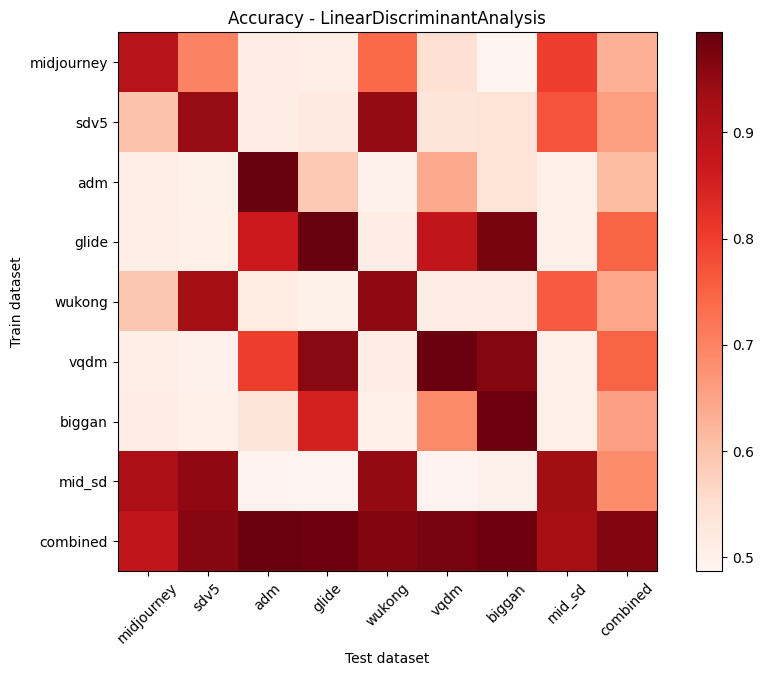

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.898,0.702,0.511,0.508,0.742,0.547,0.487,0.8000,0.627857
sdv5,0.600,0.943,0.511,0.520,0.946,0.536,0.542,0.7715,0.656857
adm,0.508,0.500,0.994,0.591,0.497,0.641,0.539,0.5040,0.610000
glide,0.507,0.502,0.866,0.992,0.510,0.885,0.975,0.5045,0.748143
wukong,0.593,0.928,0.516,0.500,0.952,0.512,0.512,0.7605,0.644714
vqdm,0.508,0.497,0.800,0.958,0.512,0.989,0.964,0.5025,0.746857
biggan,0.509,0.501,0.533,0.851,0.502,0.690,0.988,0.5050,0.653429
mid_sd,0.917,0.951,0.491,0.490,0.947,0.491,0.498,0.9340,0.683571
combined,0.885,0.962,0.990,0.987,0.965,0.978,0.985,0.9235,0.964571


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.898,0.702,0.511,0.508,0.742,0.547,0.487,0.8000,0.649375
sdv5,0.600,0.943,0.511,0.520,0.946,0.536,0.542,0.7715,0.671187
adm,0.508,0.500,0.994,0.591,0.497,0.641,0.539,0.5040,0.596750
glide,0.507,0.502,0.866,0.992,0.510,0.885,0.975,0.5045,0.717688
wukong,0.593,0.928,0.516,0.500,0.952,0.512,0.512,0.7605,0.659188
vqdm,0.508,0.497,0.800,0.958,0.512,0.989,0.964,0.5025,0.716312
biggan,0.509,0.501,0.533,0.851,0.502,0.690,0.988,0.5050,0.634875
mid_sd,0.917,0.951,0.491,0.490,0.947,0.491,0.498,0.9340,0.714875
combined,0.885,0.962,0.990,0.987,0.965,0.978,0.985,0.9235,0.959437


In [21]:
df_pivot, df_avg = present_results(df, name="LinearDiscriminantAnalysis", cmap='Reds', evaluation_data_name="Test", metric="accuracy")

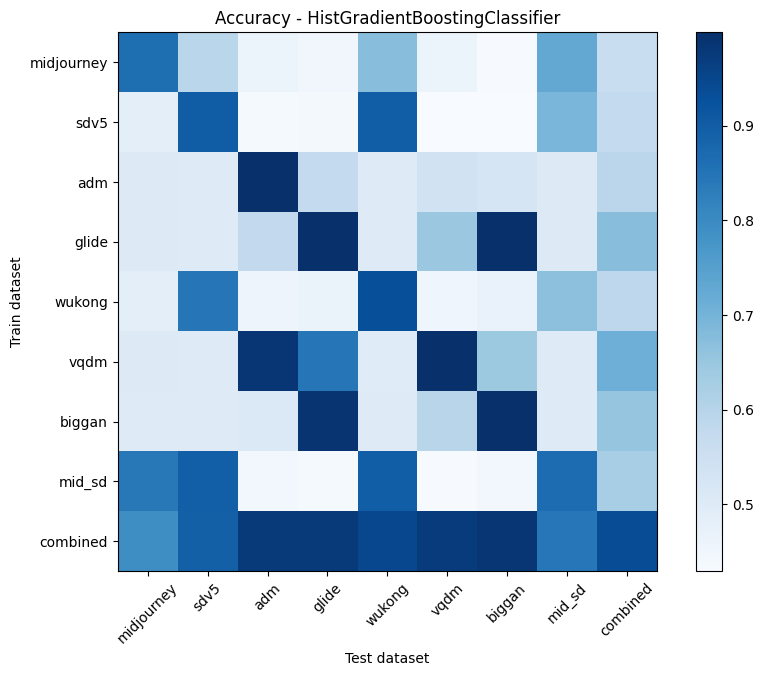

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.863,0.593,0.458,0.448,0.672,0.458,0.433,0.7280,0.560714
sdv5,0.486,0.899,0.436,0.442,0.898,0.429,0.429,0.6925,0.574143
adm,0.501,0.500,0.999,0.574,0.500,0.539,0.525,0.5005,0.591143
glide,0.501,0.500,0.576,0.999,0.499,0.645,0.996,0.5005,0.673714
wukong,0.485,0.846,0.456,0.466,0.932,0.455,0.469,0.6655,0.587000
vqdm,0.501,0.499,0.985,0.845,0.497,0.997,0.644,0.5000,0.709714
biggan,0.500,0.500,0.509,0.989,0.499,0.594,0.998,0.5000,0.655571
mid_sd,0.840,0.895,0.444,0.436,0.897,0.432,0.445,0.8675,0.627000
combined,0.793,0.893,0.976,0.978,0.946,0.973,0.985,0.8430,0.934857


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.863,0.593,0.458,0.448,0.672,0.458,0.433,0.7280,0.581625
sdv5,0.486,0.899,0.436,0.442,0.898,0.429,0.429,0.6925,0.588938
adm,0.501,0.500,0.999,0.574,0.500,0.539,0.525,0.5005,0.579813
glide,0.501,0.500,0.576,0.999,0.499,0.645,0.996,0.5005,0.652062
wukong,0.485,0.846,0.456,0.466,0.932,0.455,0.469,0.6655,0.596812
vqdm,0.501,0.499,0.985,0.845,0.497,0.997,0.644,0.5000,0.683500
biggan,0.500,0.500,0.509,0.989,0.499,0.594,0.998,0.5000,0.636125
mid_sd,0.840,0.895,0.444,0.436,0.897,0.432,0.445,0.8675,0.657062
combined,0.793,0.893,0.976,0.978,0.946,0.973,0.985,0.8430,0.923375


In [22]:
df_pivot, df_avg = present_results(df, name="HistGradientBoostingClassifier", cmap='Blues', evaluation_data_name="Test", metric="accuracy")

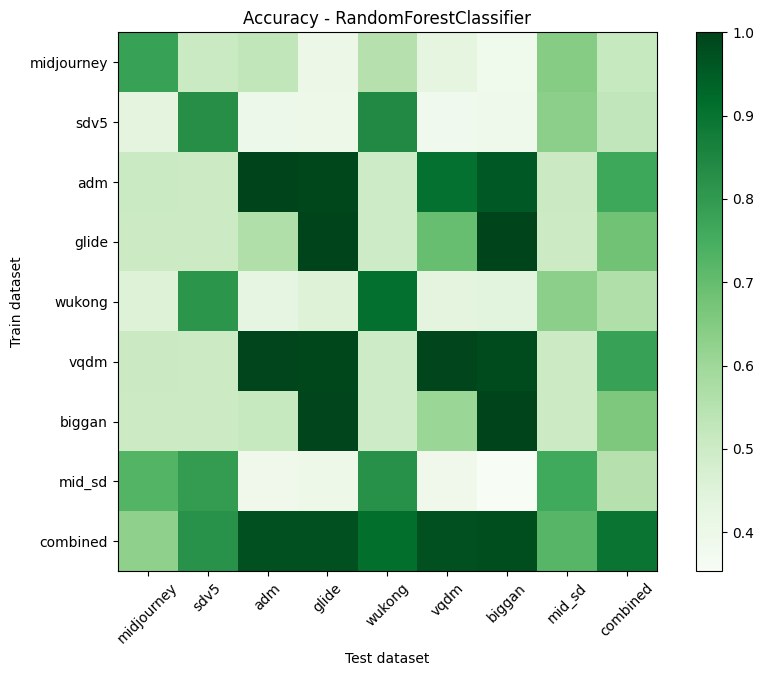

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.781,0.505,0.529,0.403,0.552,0.433,0.387,0.6430,0.512857
sdv5,0.435,0.829,0.399,0.397,0.843,0.384,0.393,0.6320,0.525714
adm,0.507,0.500,0.998,0.991,0.499,0.904,0.956,0.5035,0.765000
glide,0.500,0.500,0.565,0.998,0.499,0.696,1.000,0.5000,0.679714
wukong,0.454,0.811,0.429,0.452,0.908,0.436,0.438,0.6325,0.561143
vqdm,0.503,0.500,0.995,0.990,0.497,0.997,0.983,0.5015,0.780714
biggan,0.500,0.500,0.514,0.995,0.499,0.608,0.998,0.5000,0.659143
mid_sd,0.725,0.793,0.389,0.396,0.822,0.389,0.353,0.7590,0.552429
combined,0.626,0.819,0.973,0.973,0.914,0.973,0.980,0.7225,0.894000


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.781,0.505,0.529,0.403,0.552,0.433,0.387,0.6430,0.529125
sdv5,0.435,0.829,0.399,0.397,0.843,0.384,0.393,0.6320,0.539000
adm,0.507,0.500,0.998,0.991,0.499,0.904,0.956,0.5035,0.732312
glide,0.500,0.500,0.565,0.998,0.499,0.696,1.000,0.5000,0.657250
wukong,0.454,0.811,0.429,0.452,0.908,0.436,0.438,0.6325,0.570063
vqdm,0.503,0.500,0.995,0.990,0.497,0.997,0.983,0.5015,0.745812
biggan,0.500,0.500,0.514,0.995,0.499,0.608,0.998,0.5000,0.639250
mid_sd,0.725,0.793,0.389,0.396,0.822,0.389,0.353,0.7590,0.578250
combined,0.626,0.819,0.973,0.973,0.914,0.973,0.980,0.7225,0.872563


In [23]:
df_pivot, df_avg = present_results(df, name="RandomForestClassifier", cmap='Greens', evaluation_data_name="Test", metric="accuracy")

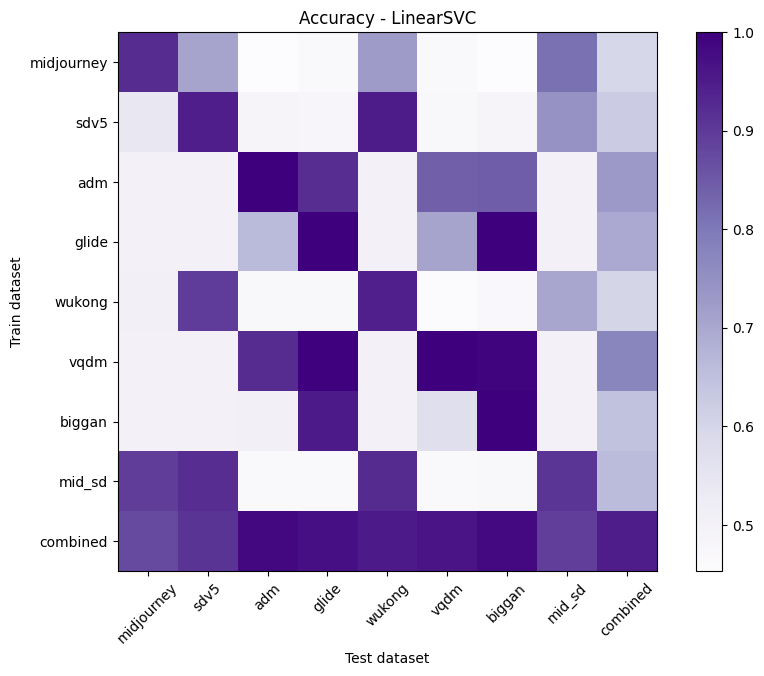

test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,combined
train_dataset,,,,,,,,,
midjourney,0.921,0.707,0.453,0.467,0.723,0.464,0.453,0.8140,0.598286
sdv5,0.539,0.945,0.483,0.480,0.950,0.473,0.483,0.7420,0.621857
adm,0.500,0.500,0.999,0.920,0.500,0.841,0.842,0.5000,0.728857
glide,0.500,0.499,0.662,0.998,0.499,0.709,1.000,0.4995,0.695286
wukong,0.506,0.896,0.473,0.472,0.944,0.458,0.468,0.7010,0.602429
vqdm,0.500,0.500,0.923,0.996,0.499,1.000,0.991,0.5000,0.772714
biggan,0.501,0.500,0.505,0.952,0.500,0.569,0.999,0.5005,0.646571
mid_sd,0.894,0.919,0.467,0.464,0.925,0.466,0.472,0.9065,0.658143
combined,0.873,0.910,0.984,0.971,0.951,0.962,0.981,0.8915,0.947429


test_dataset,midjourney,sdv5,adm,glide,wukong,vqdm,biggan,mid_sd,average
train_dataset,,,,,,,,,
midjourney,0.921,0.707,0.453,0.467,0.723,0.464,0.453,0.8140,0.625250
sdv5,0.539,0.945,0.483,0.480,0.950,0.473,0.483,0.7420,0.636875
adm,0.500,0.500,0.999,0.920,0.500,0.841,0.842,0.5000,0.700250
glide,0.500,0.499,0.662,0.998,0.499,0.709,1.000,0.4995,0.670813
wukong,0.506,0.896,0.473,0.472,0.944,0.458,0.468,0.7010,0.614750
vqdm,0.500,0.500,0.923,0.996,0.499,1.000,0.991,0.5000,0.738625
biggan,0.501,0.500,0.505,0.952,0.500,0.569,0.999,0.5005,0.628312
mid_sd,0.894,0.919,0.467,0.464,0.925,0.466,0.472,0.9065,0.689188
combined,0.873,0.910,0.984,0.971,0.951,0.962,0.981,0.8915,0.940438


In [24]:
df_pivot, df_avg = present_results(df, name="LinearSVC", cmap='Purples', evaluation_data_name="Test", metric="accuracy")

## Save models and scalers

In [25]:
# for each dataset save models and scalers
import joblib

for dataset_name in models.keys():
    for model_name, model in models[dataset_name].items():
        models_dir_path = f"models/GenImage512x512/standardJpg100/{dataset_name}"
        scalers_dir_path = f"scalers/GenImage512x512/standardJpg100/{dataset_name}"
        os.makedirs(models_dir_path, exist_ok=True)
        os.makedirs(scalers_dir_path, exist_ok=True)
        joblib.dump(model, os.path.join(models_dir_path, f"{dataset_name}_{model_name}.joblib"))
        joblib.dump(scalers[dataset_name], os.path.join(scalers_dir_path, f"{dataset_name}_{model_name}.joblib"))